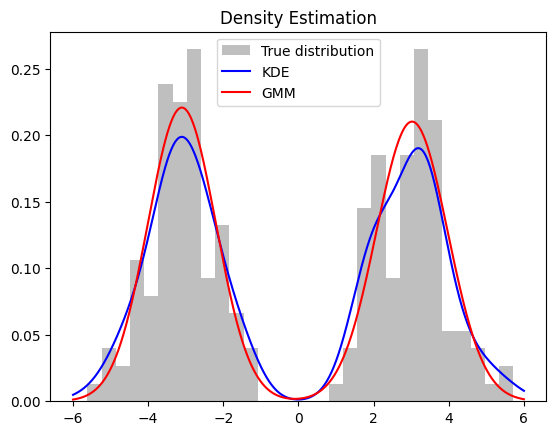

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

# Генерация случайных данных
np.random.seed(42)
data = np.concatenate([
    np.random.normal(loc=-3, scale=1, size=(100, 1)),
    np.random.normal(loc=3, scale=1, size=(100, 1))
])

# Визуализация исходных данных
plt.hist(data, bins=30, density=True, alpha=0.5, color='gray', label='True distribution')

# 1. Метод Ядерного Сглаживания (Kernel Density Estimation)
def kernel_density_estimation(data, bandwidth=0.5):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data)
    return kde

kde = kernel_density_estimation(data)
x_plot = np.linspace(-6, 6, 1000)[:, np.newaxis]
kde_density = np.exp(kde.score_samples(x_plot))
plt.plot(x_plot, kde_density, label='KDE', color='blue')

# 2. Метод EM (Gaussian Mixture Model)
def em_density_estimation(data, n_components=2):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data)
    return gmm

gmm = em_density_estimation(data)
gmm_density = np.exp(gmm.score_samples(x_plot))
plt.plot(x_plot, gmm_density, label='GMM', color='red')

plt.legend()
plt.title('Density Estimation')
plt.show()

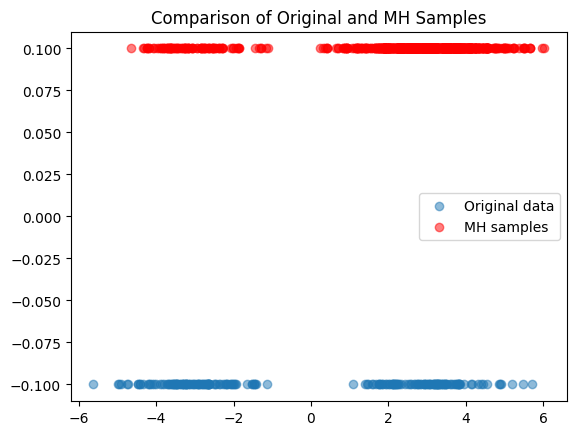

In [12]:
def metropolis_hastings(target_density, proposal, num_samples, start_point):
    samples = []
    current = start_point
    for _ in range(num_samples):
        proposed = proposal(current)
        acceptance_ratio = target_density(proposed) / target_density(current)
        if np.random.rand() < acceptance_ratio:
            current = proposed
        samples.append(current)
    return np.array(samples)

# Целевая плотность, полученная из GMM
def gmm_density(point):
    return np.exp(gmm.score_samples(point.reshape(1, -1)))[0]

# Предложение нового состояния
def proposal(current):
    return current + np.random.normal(loc=0, scale=1)

mh_samples = metropolis_hastings(gmm_density, proposal, 1000, start_point=np.array([0.0]))

# Визуализация результатов
plt.scatter(data, np.zeros_like(data) - 0.1, alpha=0.5, label='Original data')
plt.scatter(mh_samples, np.zeros_like(mh_samples) + 0.1, alpha=0.5, label='MH samples', color='red')
plt.legend()
plt.title('Comparison of Original and MH Samples')
plt.show()


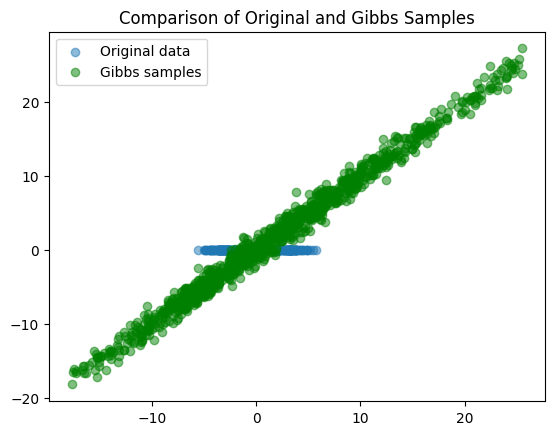

In [13]:
def gibbs_sampling(joint_density, num_samples, start_point):
    samples = [start_point]
    current = start_point.copy()
    for _ in range(num_samples):
        # Обновление первого параметра
        current[0] = np.random.normal(loc=current[1], scale=1)
        # Обновление второго параметра
        current[1] = np.random.normal(loc=current[0], scale=1)
        samples.append(current.copy())
    return np.array(samples)

# Применение Гиббса на основе GMM
gibbs_samples = gibbs_sampling(gmm_density, 1000, start_point=np.array([0.0, 0.0]))

# Визуализация
plt.scatter(data, np.zeros_like(data) - 0.1, alpha=0.5, label='Original data')
plt.scatter(gibbs_samples[:, 0], gibbs_samples[:, 1], alpha=0.5, label='Gibbs samples', color='green')
plt.legend()
plt.title('Comparison of Original and Gibbs Samples')
plt.show()


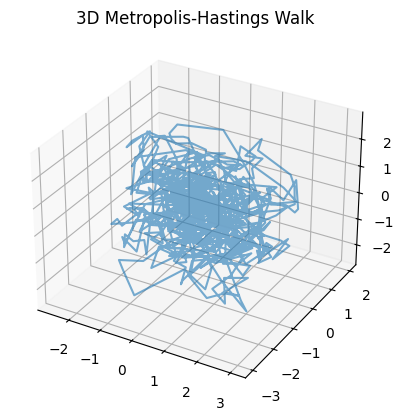

In [14]:
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

def three_dim_proposal(current):
    return current + np.random.normal(loc=0, scale=0.5, size=current.shape)

def three_dim_density(point):
    mean = np.zeros(3)
    cov = np.eye(3)
    return multivariate_normal.pdf(point, mean=mean, cov=cov)

three_dim_samples = metropolis_hastings(three_dim_density, three_dim_proposal, 1000, start_point=np.array([0.0, 0.0, 0.0]))

# Визуализация блуждания в 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(three_dim_samples[:, 0], three_dim_samples[:, 1], three_dim_samples[:, 2], alpha=0.6)
plt.title('3D Metropolis-Hastings Walk')
plt.show()


In [15]:
from scipy.stats import entropy

def kl_divergence(p, q):
    return entropy(p, q)

# Сравнение гистограмм для KL-дивергенции
original_hist, bins = np.histogram(data, bins=30, density=True)
mh_hist, _ = np.histogram(mh_samples, bins=bins, density=True)

# Выравнивание гистограмм
original_hist += 1e-10
mh_hist += 1e-10

kl_div = kl_divergence(original_hist, mh_hist)
print(f'KL-Div: {kl_div}')


KL-Div: 1.3647311670275732
